<a href="https://colab.research.google.com/github/neel-machine/News-recommendation-system/blob/main/news_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd


In [3]:
con_data = pd.read_csv('drive/My Drive/consumer_transanctions.csv')
con_data.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [4]:
con_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


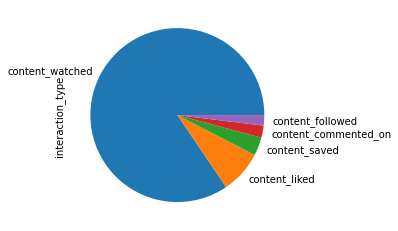

In [5]:
con_data.interaction_type.value_counts().plot(kind = 'pie')

In [6]:
con_data.consumer_location.nunique()

71

Consumer location unique value indicates that users from 71 different cities are using this application. Lets see the top 10 locations

In [7]:
con_data.consumer_location.value_counts()[:10]

SP    40164
MG    10229
NY     1257
TX      923
GA      910
RJ      775
NJ      698
?       327
CA      238
ON      202
Name: consumer_location, dtype: int64

In [8]:
con_data.country.value_counts()

BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
ZZ       11
SG       11
AR        7
PT        6
ES        3
IN        3
MY        2
IT        2
CN        1
NL        1
CL        1
CO        1
CH        1
Name: country, dtype: int64

country details indicate that majority of hits come from USA and Brazil. They both constitute 77.5 % of total hits

In [9]:
len(con_data[(con_data.country == 'US' )] + con_data[(con_data.country == 'BR' )])/con_data.shape[0] * 100

77.51548843898661

In [10]:
con_data.shape[0]


72312

Lets remove rest of the columns from the dataset and only keep item_id,consumer_id and interaction type. We will generate ratings from interaction type column which will become an important feature for this recommendation system.

In [11]:
con_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


In [12]:
con_data = con_data[["interaction_type","consumer_id","item_id"]]

In [13]:
con_data.head()

,interaction_type,consumer_id,item_id
0,content_watched,-8845298781299428018,-3499919498720038879
1,content_watched,-1032019229384696495,8890720798209849691
2,content_watched,-1130272294246983140,310515487419366995
3,content_followed,344280948527967603,310515487419366995
4,content_watched,-445337111692715325,-7820640624231356730


In [14]:
con_data.interaction_type.value_counts()

content_watched         61086
content_liked            5745
content_saved            2463
content_commented_on     1611
content_followed         1407
Name: interaction_type, dtype: int64

In [15]:
interactions = con_data.interaction_type.value_counts()*100/con_data.shape[0]

In [16]:
engagement_df = pd.DataFrame(interactions)

In [17]:
engagement_df

,interaction_type
content_watched,84.475606
content_liked,7.944739
content_saved,3.406074
content_commented_on,2.227846
content_followed,1.945735


In [18]:
engagement_df.reset_index(inplace=True)

In [19]:
engagement_df

,index,interaction_type
0,content_watched,84.475606
1,content_liked,7.944739
2,content_saved,3.406074
3,content_commented_on,2.227846
4,content_followed,1.945735


In [20]:
engagement_df.columns = ["interaction_type","value"]

In [21]:
engagement_df

,interaction_type,value
0,content_watched,84.475606
1,content_liked,7.944739
2,content_saved,3.406074
3,content_commented_on,2.227846
4,content_followed,1.945735


Lets impute rating value into the dataset. Lets assign ratings from 1 to 5 , 5 being the highest. content_liked should have highest rating because a customer has liked something, followed by content_followed, content_saved,content_watched and content_comented_on.

In [22]:
engagement_df['ratings'] = 100/engagement_df.value

In [23]:
engagement_df

,interaction_type,value,ratings
0,content_watched,84.475606,1.183774
1,content_liked,7.944739,12.586945
2,content_saved,3.406074,29.359318
3,content_commented_on,2.227846,44.886406
4,content_followed,1.945735,51.394456


In [24]:
con_data_mod = pd.merge(con_data,engagement_df,on='interaction_type')

In [25]:
con_data_mod.sample(20)

,interaction_type,consumer_id,item_id,value,ratings
55469,content_watched,5497189205340943824,3751305746867503759,84.475606,1.183774
27083,content_watched,-6944500707172804068,7459726589306441015,84.475606,1.183774
71731,content_commented_on,5660542693104786364,-8243488279185272615,2.227846,44.886406
59999,content_watched,5573804063428996341,3772685586944428188,84.475606,1.183774
12759,content_watched,8437083040455072898,6044362651232258738,84.475606,1.183774
226,content_watched,8615245686887763683,1738052593226421681,84.475606,1.183774
44556,content_watched,-5201927981686846343,-4084394822880420062,84.475606,1.183774
57674,content_watched,4989759812391042852,-3224698078244963479,84.475606,1.183774
1899,content_watched,-1616903969205976623,-401664538366009049,84.475606,1.183774
2884,content_watched,-9009798162809551896,-4374331682165863764,84.475606,1.183774


In [26]:
con_data_mod.drop(['interaction_type','value'],axis = 1,inplace=True)

In [27]:
con_data_mod.drop_duplicates(inplace=True)

In [28]:
con_data_mod.shape

(50938, 3)

In [29]:
con_data.consumer_id.nunique()

1895

We have merged two dataframes and now we also removed duplicates leaving us with 50938 rows. Since we have negative values in consumer_id column, and it will be a problem when we want to cream user matrix we will map these ids to column have rows from 0 to 1895

In [30]:
con_data_mod['news_id'] = con_data_mod.groupby(['item_id']).ngroup()

In [31]:
con_data_mod.head()

,consumer_id,item_id,ratings,news_id
0,-8845298781299428018,-3499919498720038879,1.183774,933
1,-1032019229384696495,8890720798209849691,1.183774,2933
2,-1130272294246983140,310515487419366995,1.183774,1537
3,-445337111692715325,-7820640624231356730,1.183774,246
4,-8763398617720485024,310515487419366995,1.183774,1537


In [32]:
con_data_mod['user_id'] = con_data_mod.groupby(['consumer_id']).ngroup()

In [33]:
con_data_mod.sample(30)

,consumer_id,item_id,ratings,news_id,user_id
52867,-2820994773540913369,7850245260835292221,1.183774,2762,667
32042,2903276950629630374,-8018192200278263695,1.183774,221,1241
8688,-1032019229384696495,5379671084978512851,1.183774,2359,831
61566,-5868110530814399805,7734121175534200554,51.394456,2744,333
60246,-1032019229384696495,-5082274522455747241,1.183774,684,831
14629,3938645257702379823,5238119115012015307,1.183774,2330,1358
29097,3636910968448833585,-548976469460064550,1.183774,1393,1323
43878,3609194402293569455,1106203543388094548,1.183774,1658,1319
67903,-2511855597392146401,-4974757204495953627,12.586945,708,693
49647,-9016528795238256703,-8954346068661072425,1.183774,63,17


In [34]:
ratings = con_data_mod[["ratings","news_id","user_id"]]

In [35]:
ratings.head()

,ratings,news_id,user_id
0,1.183774,933,33
1,1.183774,2933,831
2,1.183774,1537,826
3,1.183774,246,887
4,1.183774,1537,42


In [36]:
num_newsid = ratings.news_id.nunique()

In [37]:
num_users = ratings.user_id.nunique()

## Create a user-news matrix
to impement collaborative filtering , which is depending on one user's choices we will match him with users that have similar choices and assume that recommendations from user2 will match user1 viewing pattern

In [38]:
import numpy as np


In [39]:
data_mtrix = np.zeros((num_users,num_newsid))

In [40]:
data_mtrix.shape

(1895, 2987)

In [41]:
ratings.head()

,ratings,news_id,user_id
0,1.183774,933,33
1,1.183774,2933,831
2,1.183774,1537,826
3,1.183774,246,887
4,1.183774,1537,42


In [42]:
for line in ratings.itertuples():
  #print(line)
  data_mtrix[line[3]-1,line[2]-1] = line[1]

In [43]:
data_mtrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [12.58694517,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Pairwise similarity among users in data matrix
Using cosine similarity we will find it

In [44]:
from sklearn.metrics.pairwise import pairwise_distances

In [45]:
user_similarity = 1 - pairwise_distances(data_mtrix,metric='cosine')

In [46]:
user_similarity

array([[1.        , 0.04126165, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04126165, 1.        , 0.        , ..., 0.11931198, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.01447859],
       ...,
       [0.        , 0.11931198, 0.        , ..., 1.        , 0.        ,
        0.02146289],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.00361512],
       [0.        , 0.        , 0.01447859, ..., 0.02146289, 0.00361512,
        1.        ]])

In [47]:
user_similarity.shape

(1895, 1895)

In [48]:
news_prediction = np.dot(user_similarity,data_mtrix)

In [49]:
news_prediction.shape

(1895, 2987)

In [50]:
news_prediction

array([[1.10060679e+01, 1.15079006e-02, 2.06998456e-01, ...,
        3.43758566e-01, 1.91907864e-02, 9.94563495e-02],
       [3.88853857e+01, 4.70360145e-01, 3.41623071e+00, ...,
        1.69204430e-01, 8.38454616e-02, 5.00817746e-01],
       [2.59663740e-03, 2.61521397e-02, 1.03324386e-01, ...,
        5.56986431e-02, 2.00021300e-03, 3.46149782e+00],
       ...,
       [3.74260402e+00, 4.30860355e+00, 6.29464379e+00, ...,
        6.91298536e-01, 1.25806138e-01, 3.37204519e+00],
       [2.47923200e-01, 1.90790840e+00, 5.07918670e+00, ...,
        5.40641715e-01, 1.01162451e-01, 4.67052193e-01],
       [7.18868464e-01, 1.36999996e+00, 3.61889932e+00, ...,
        7.91271068e-01, 1.13733969e-01, 1.03874652e+01]])

We have user vs item prediction matrix, we can use this and extract top 10 items for each user

In [51]:
predicted_news_df = pd.DataFrame(news_prediction)

In [52]:
predicted_news_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,11.006068,0.011508,0.206998,0.000000,0.884925,0.000000,0.197372,0.036644,0.000000,0.038060,...,0.131052,0.006114,0.002623,0.124741,0.003459,0.015756,0.099962,0.343759,0.019191,0.099456
1,38.885386,0.470360,3.416231,0.261110,0.808605,0.000000,1.645028,0.003568,0.134712,0.120343,...,0.601529,0.037855,0.013208,0.081676,0.107422,0.170919,0.625144,0.169204,0.083845,0.500818
2,0.002597,0.026152,0.103324,0.028332,0.037763,0.000000,0.246287,0.000000,0.027202,0.000000,...,0.311888,0.059949,0.088733,0.016092,0.004435,0.137354,0.733609,0.055699,0.002000,3.461498
3,0.000000,7.168110,2.187243,0.018246,3.100368,0.002576,0.066585,0.003021,0.024851,0.048848,...,0.048366,0.033382,0.004532,0.628844,0.490164,0.254464,0.009942,0.285227,0.012618,0.196767
4,0.038039,0.057784,0.675224,0.014798,0.165965,0.000620,0.102406,0.025741,0.281964,0.026437,...,0.040365,0.014788,0.000443,0.181702,0.188245,0.088917,0.259286,0.138219,0.011920,0.031503


Lets do top 10 predicted news for user 17

In [53]:
reco_17 = pd.DataFrame(predicted_news_df.iloc[17].sort_values(ascending = False))

In [54]:
reco_17.head(10)

,17
104,37.057980
575,28.271341
1540,23.619458
1745,9.191277
2356,8.174512
1095,8.113203
2267,7.666258
522,7.373053
1511,6.776075
1983,6.698619


In [55]:
reco_17.reset_index(inplace=True)

In [56]:
reco_17.columns = ['news_id','score']

In [57]:
reco_17.head()

,news_id,score
0,104,37.057980
1,575,28.271341
2,1540,23.619458
3,1745,9.191277
4,2356,8.174512


In [58]:
con_data_mod.head()

,consumer_id,item_id,ratings,news_id,user_id
0,-8845298781299428018,-3499919498720038879,1.183774,933,33
1,-1032019229384696495,8890720798209849691,1.183774,2933,831
2,-1130272294246983140,310515487419366995,1.183774,1537,826
3,-445337111692715325,-7820640624231356730,1.183774,246,887
4,-8763398617720485024,310515487419366995,1.183774,1537,42


In [59]:
item_map = con_data_mod[['news_id','item_id']]

In [60]:
item_map.shape

(50938, 2)

In [61]:
item_mapping = item_map.drop_duplicates()

In [62]:
item_mapping.head()

,news_id,item_id
0,933,-3499919498720038879
1,2933,8890720798209849691
2,1537,310515487419366995
3,246,-7820640624231356730
5,82,-8864073373672512525


In [63]:
reco_merge_17  = pd.merge(reco_17,item_mapping,how='left',on='news_id')

In [64]:
reco_merge_17

,news_id,score,item_id
0,104,37.057980,-8722526817358894474
1,575,28.271341,-5750828394349042089
2,1540,23.619458,335910242745901755
3,1745,9.191277,1632166079091127830
4,2356,8.174512,5338575284381070077
...,...,...,...
2982,1094,0.000000,-2375266175756882986
2983,1096,0.000000,-2358756719610361882
2984,1097,0.000000,-2358644309529026633
2985,1098,0.000000,-2355230755276061204


In [65]:
content = pd.read_csv('drive/My Drive/platform_content.csv')


In [66]:
content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [67]:
title_map = content[['item_id','title']]
title_map.head()

,item_id,title
0,-6451309518266745024,"Ethereum, a Virtual Currency, Enables Transact..."
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact..."
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...
3,-6151852268067518688,Google Data Center 360° Tour
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc..."


In [68]:
final_reco = pd.merge(title_map,reco_merge_17,on='item_id',how='left')

In [69]:
final_reco.head()

,item_id,title,news_id,score
0,-6451309518266745024,"Ethereum, a Virtual Currency, Enables Transact...",472.0,0.008229
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",835.0,0.000000
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,333.0,0.000000
3,-6151852268067518688,Google Data Center 360° Tour,510.0,0.000000
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",NaN,NaN


In [70]:
final_reco['collaborative_score'] = (final_reco.score - min(final_reco.score))/(max(final_reco.score) - min(final_reco.score))
final_reco.head()

,item_id,title,news_id,score,collaborative_score
0,-6451309518266745024,"Ethereum, a Virtual Currency, Enables Transact...",472.0,0.008229,0.000222
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",835.0,0.000000,0.000000
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,333.0,0.000000,0.000000
3,-6151852268067518688,Google Data Center 360° Tour,510.0,0.000000,0.000000
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",NaN,NaN,NaN


In [71]:
final_reco.sort_values(by=['collaborative_score'],ascending = False)

,item_id,title,news_id,score,collaborative_score
833,-8722526817358894474,VR possibilities at Google I/O 2016: Four thin...,104.0,37.057980,1.000000
2427,-5750828394349042089,Artificial Intelligence Software Is Booming. B...,575.0,28.271341,0.762895
2023,335910242745901755,"Inbox by Gmail ganha integração com Trello, Gi...",1540.0,23.619458,0.637365
1066,1632166079091127830,Cinco dicas de executivos de sucesso para se d...,1745.0,9.191277,0.248024
995,5338575284381070077,A Major Law Firm Will Soon Be Using A Robotic ...,2356.0,8.174512,0.220587
...,...,...,...,...,...
2643,7636423839699365160,Twitter's sales team may take a hit in big upc...,NaN,NaN,NaN
2683,5688444173453700360,A Tale of 2 API Platforms - GGV Capital,NaN,NaN,NaN
2709,4422997595777504091,Google Home brings Google's smarts to your liv...,NaN,NaN,NaN
2767,-253149055249888078,Google Is in a Fierce Global Race for Scarce A...,NaN,NaN,NaN


In [72]:
final_reco.head()

,item_id,title,news_id,score,collaborative_score
0,-6451309518266745024,"Ethereum, a Virtual Currency, Enables Transact...",472.0,0.008229,0.000222
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",835.0,0.000000,0.000000
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,333.0,0.000000,0.000000
3,-6151852268067518688,Google Data Center 360° Tour,510.0,0.000000,0.000000
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",NaN,NaN,NaN


## MAE

In [75]:
from sklearn.metrics import mean_absolute_error

In [77]:
def mae(predicted,ground_truth):
  pr = predicted[ground_truth.nonzero()]
  gt = ground_truth[ground_truth.nonzero()]
  return mean_absolute_error(pr,gt)

In [78]:
mae(news_prediction,data_mtrix)

13.871506912661735